
# A Financial Model for Sustaining the Expense of Eagle Lake Dam Indefinitely


### Abstract

The concept of a perpetuity is introduced and explored, first with a fixed-growth-rate, and then extending into a Monte Carlo simulation by accounting for real-world volatility.  Inflation data and stock market data are used to estimate payment and principle growth and volatility.  

Monte Carlo analysis shows that the ideal case presented in a fixed-rate model is inadequate, as often the funds in the perpetuity are exhaused, even after 25.  

Strategies for minimizing the likelihood of exhausing the funds in the perpetuity are explored, including over-funding and increased risk-taking.

### Introduction

Wikipedia defines a [perpetuity](https://en.wikipedia.org/wiki/Perpetuity) as "an annuity that has no end, or a stream of cash payments that continues forever."  It's a financial arrangement where a payment of predicable size is given from an invested prinicple at a regular interval.  An initial principle is chosen, and invested as such a growth rate that the payment can be made indefinitely, given adherence to some assumptions.

The initial principle is defined by the size of the initial payment, the rate of growth of the principle, and the rate of growth of the payment.  The rate of growth of the payment can be chosen to reflect inflation.  The rate of return of the principle can be chosen from historical data of the intended investment.

`Initial Principle = Initial Payment / (growth of investment - growth of payment)`

This model does not fully reflect reality.  Inflation and investment returns are not fixed constants.  Interest rates vary, stock market returns are volatile, and inflation fluctuates.  Modeling for these variations is done by adding variation to each interval's growth rates.  In a Monte Carlo simulation, a normal distribution about an emperical standard deviation is chosen to produce a simulation of the volatility observed in real life. 

In [278]:
library(ggplot2)
library(dplyr)

In [262]:
## Some initial conditions

# Number of years to model
years <- 100

# For randomized results, number of test runs to perform
test_runs <- 1000

### Inflation Data

To apply a reasonable value for the growth rate and variation of the payment, inflation data is gathered from the [Bureau of Labor Statistics](http://data.bls.gov/pdq/SurveyOutputServlet).  BLS measures and reports consumer price index on a monthly basis.  A snapshot of the data from 2000 to present is captured, and then the annualized data is converted to a mean inflation rate and a standard deviation.  These values are then used for the payment growth rate and variation, respectively.

In [263]:
inflation_data_string <- "Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
2000,176.2,177.6,178.5,178.5,178.4,179.0,179.8,179.9,180.7,181.2,181.5,181.3,179.4,178.0,180.7
2001,182.2,182.8,183.7,184.2,184.6,185.3,185.0,185.1,185.1,185.0,185.0,184.2,184.4,183.8,184.9
2002,184.9,186.1,187.0,187.8,187.7,187.8,188.3,189.3,189.5,189.9,190.1,189.6,188.2,186.9,189.5
2003,190.5,191.7,193.0,192.6,192.7,192.8,193.5,194.3,195.0,195.4,195.1,194.9,193.5,192.2,194.7
2004,195.9,196.8,198.6,199.4,199.9,201.1,201.0,201.0,201.2,202.5,202.6,201.9,200.2,198.6,201.7
2005,202.6,203.6,206.0,206.9,206.2,206.2,207.9,208.7,210.8,211.5,210.0,209.0,207.5,205.3,209.7
2006,211.0,211.6,212.8,214.7,215.7,216.7,217.5,218.1,216.3,215.2,214.8,215.2,215.0,213.8,216.2
2007,215.813,216.651,218.334,219.501,220.591,221.579,221.945,221.559,221.436,221.951,223.356,223.425,220.512,218.745,222.279
2008,224.325,225.213,226.926,228.133,230.089,232.649,234.545,233.788,232.841,230.837,227.236,225.091,229.306,227.889,230.723
2009,225.436,226.754,227.309,227.840,228.136,229.930,230.154,230.883,231.200,231.304,231.708,231.462,229.343,227.568,231.119
2010,232.294,232.382,233.188,233.615,234.130,233.834,233.885,234.150,234.027,234.671,235.094,235.141,233.868,233.241,234.495
2011,235.969,237.110,239.074,240.267,241.566,241.690,242.282,243.033,243.323,243.014,242.652,241.987,240.997,239.279,242.715
2012,242.879,243.850,245.125,245.850,245.709,245.201,244.984,246.252,247.409,247.564,247.097,246.456,245.698,244.769,246.627
2013,247.277,248.665,248.719,248.464,248.584,248.851,249.411,249.858,250.231,249.320,249.503,249.567,249.038,248.427,249.648
2014,251.045,251.233,252.413,252.506,253.598,253.555,253.833,253.185,253.154,252.730,251.781,250.519,252.463,252.392,252.534
2015,250.016,250.619,251.451,251.760,252.770,253.626,253.405,252.903,252.922,252.504,252.573,251.670,252.185,251.707,252.663
2016,251.739, , , , , , , , , , , , , , "

inflation_data <- read.csv(text=inflation_data_string)
inflation_data <- inflation_data %>% select(-Year, -HALF1, -HALF2)

to_annual_percent <- function(row) {
    start = row[1]
    pct <- c()
    for (i in 2:length(row)) {
        if (is.na(row[i])) { return (pct) }
        pct <- c(pct, row[i]/start)
        start <- row[i]
    }
    return(pct)
}

annualized_inflation <- to_annual_percent(inflation_data[,'Annual'])
payment.growth_rate <- 100*(mean(annualized_inflation)-1)
payment.growth_std <- sd(annualized_inflation)*100

cat(sprintf("Payment Growth Rate %.2f %%\n", payment.growth_rate))
cat(sprintf("Payment Growth Variation (std) %.2f %%\n", payment.growth_std))


Payment Growth Rate 2.30 %
Payment Growth Variation (std) 1.25 %


### Anticipated Growth of Principle

Foundationally, the growth rate of the principle must exceed the growth rate of the payment; failing to satisfy this condition results in the principle quickly being exhausted.  [Indeed, as explored later, if the growth rate is not *sufficiently above* the payment growth rate, volatility will raise the likelihood exhausting the principle] 

There are no risk-free investments that exceed the rate of inflation.  Investment in a diverse stock portfolio, following the concepts of Modern Portfolio Therory, achieves an optimal return for a given volatility.  Choosing a modest return target and accepting the associated volatility is a starting point.  

Actual risk and return data was surprisingly hard to come by.  The web site [ifa.com](https://www.ifa.com/calculator) provides some data that can be manually scraped.  THe portfolios approach the efficient frontier, i.e. optimal risk/return.  

Portfolio 50 is split equally between diversified bonds and diversified stocks, and is as good of a place to start as any.  The date range chosen is from January 2000 to present (February 2016).  Agurably, this might be too short a duration, as the time horizon of a perptuity is far longer.  However, this is a conservative approach because the returns are lowewr and volatilities higher than over a longer historical period.  And, it is the same duration over which inflation data was collected.

In [264]:
## span of January 2000 to February 2016, inclusive, for Portfolio 50.  
principle.growth_rate <- 5.43  ## Portfolio 50
principle.growth_std <- 8.47   ## Portfolio 50

### Estimating the expenses

The regular payment from the perpetuity is an infation-adjusted value based on an initial estimate.  An initial value can be chosen from an historical record of expenses incurred.  

Future work may add variation into the sequence of payments, e.g. a bimodal profile where expenses vary from low one year to high the next, and then low again.  

In [265]:
## This is nothing more than a guess.  
payment.initial <- 3000

### Objective

Given the equation for a perpetuity, and having now chosen interest rates and an annual payment, calculate the initial principle required.

In [167]:
principle.initial <- payment.initial/(principle.growth_rate - payment.growth_rate)*100
cat(sprintf("The principle required $%.0f\n", principle.initial))

The principle required $95952


### Objective

Given the expected growth rates, and the equation for a perpetuity, plot the principle for the time period under consideration.  This reflects an ideal outcome:  there is neither too little principle to sustain the series or payments, nor an excess of principle that would be better put to other uses.  

-----
#### Method
If given a rate of return for investment and an inflation rate for a given time period, how to calculate the principle and payment for the next time period?  The following function takes initial values for principle and payment, time series of principle and payment growths, and returns a series of principles.

The time-series of growth rates  may vary from year to year, or they may be constant (or even zero).  If the principle is exhausted before the end of the time series, it will be held to zero.  

There is no explicit timebase here.  The timebase is embedded in the growth rate series.  If they are per-year or per-quarter, then that is reflected in the output.  

In [266]:
calc_principles_series <- function(principle, payment, pri_gr, pay_gr, acc) {
    if (length(pay_gr) == 0 ) { return(acc) }
    if (length(pri_gr) == 0 ) { return(acc) }
    principle = principle * (1 + pri_gr[1]/100) - payment
    if (principle < 0) { principle = 0 }
    payment = payment * (1 + pay_gr[1]/100)
    acc = c(acc, principle)
    calc_principles_series(principle, payment, tail(pri_gr,-1), tail(pay_gr, -1), acc)
}

In [267]:
## Apply a fixed principle and payment growth rate across the time series.  
principle.non_stochastic_series <- calc_principles_series(principle.initial, 
                                  payment.initial, 
                                  rep(principle.growth_rate, each=years), 
                                  rep(payment.growth_rate, each=years), 
                                  c())

## A function to be used with apply() to accumulate a running return. 
## This is useful for calculating the growth of a payment.  
cummulative_growth <- function(x) {
    result = c()
    acc = 1
    for (v in x) {
        acc = acc * (1+v/100)
        result = c(result, acc)
    }
    return (result)
}
## apply a fixed payment growth rate across the time series. 
payment.non_stochastic_series <- payment.initial * 
    apply(matrix(data=rep(payment.growth_rate, each=years), ncol = 1), 2, cummulative_growth)

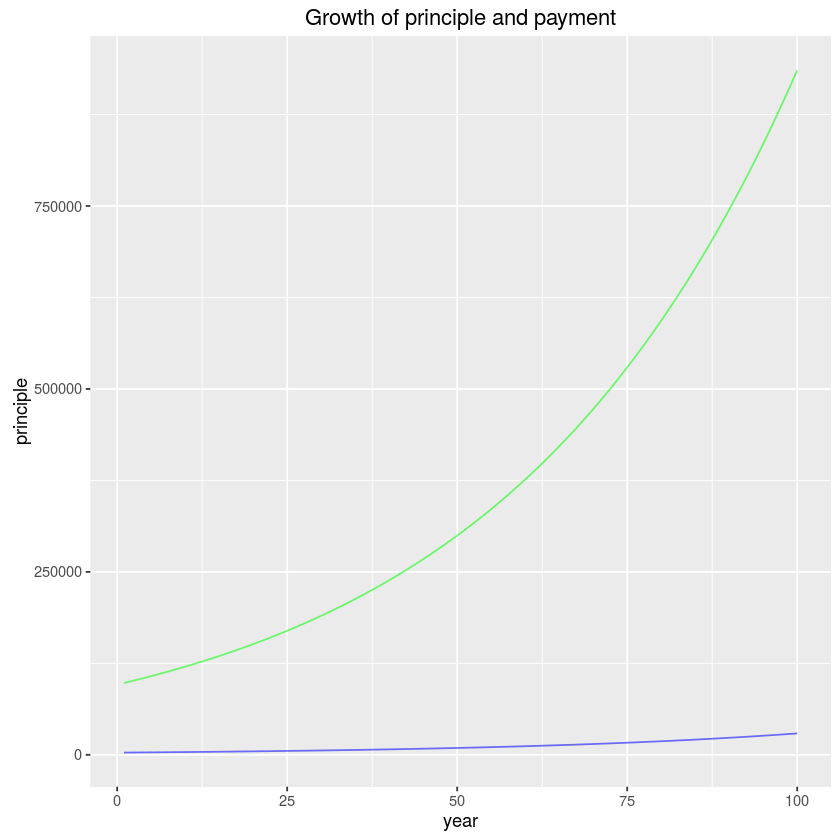

In [270]:
plot <- ggplot() + 
    geom_line(data=data.frame(year=1:years, principle=principle.non_stochastic_series), 
        aes(x=year, y=principle, alpha=0.1), color='green') + 
    theme(legend.position="None")

plot + geom_line(data=data.frame(year=1:years, payment=payment.non_stochastic_series), 
        aes(x=year, y=payment, alpha=0.1), color='blue') + 
    theme(legend.position="None") + ggtitle("Growth of principle and payment")


### Analyzing the effects of  Volatility

The model above does not consider volatility.  The next step is to consider the effect of varying rate of returns, sometimes negative, for the principle and for inflation.  To achive this, perform not just one, but many test runs, where the growth rates vary as specified by their respective standard deviations.

In [271]:
#set.seed(100+N)

## Generate N columns
N <- test_runs
df <- data.frame( year=1:years)
for (n in 1:N ) {
    principle.growth <- 
        rnorm(years,principle.growth_rate,principle.growth_std)
    payment.growth <- 
        rnorm(years, payment.growth_rate, payment.growth_std)
    col <- calc_principles_series(principle.initial, 
                                  payment.initial, 
                                  principle.growth, 
                                  payment.growth, 
                                  c())
    df <- cbind(df, col)
}
#df <- df[,-1]  ## Drop the year column?
names(df) <- c('year', 1:N)
##dim(df)

### Objective

Plot each of the many samples on the same chart.  What might it suggest about the sustainability of a perpetuity as modeled?

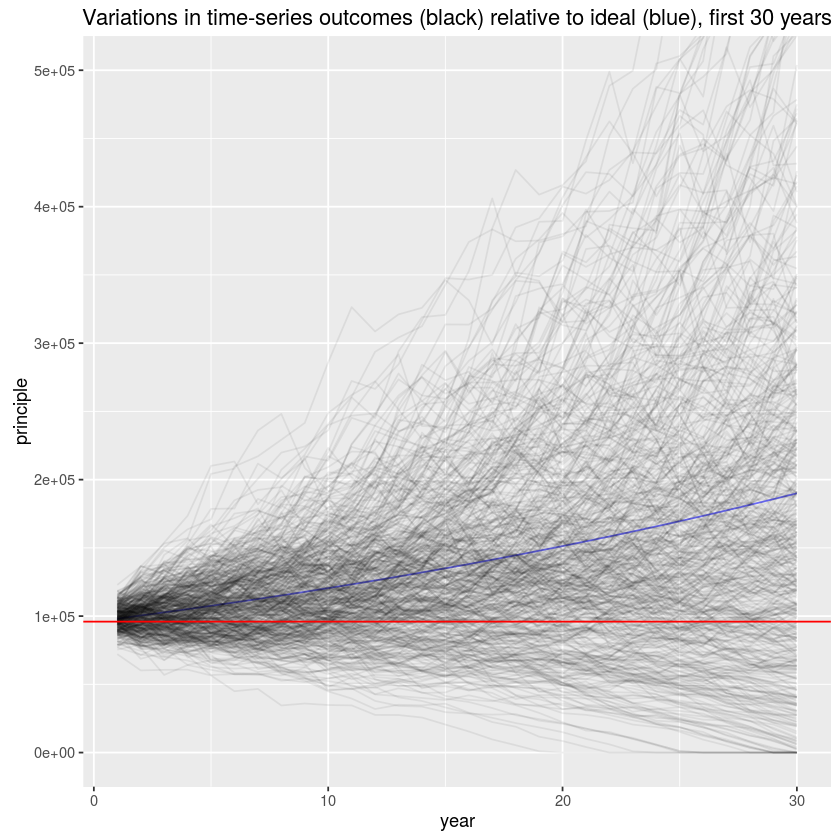

In [288]:
#qplot(x=1:100, y=df[,2], geom="line", alpha=0.2)
#ggplot(df, aes(x=))

## An idea for plotting multiple columns from 
## http://stackoverflow.com/questions/19921842/plotting-multiple-time-series-on-the-same-plot-using-ggplot


## Tried plotting 100 years, but the Y axis goes to high. 
## Tried limiting that, and while it's an interesting visualization, 
## it's not going to be helpful to the casual reader.  

test_runs_to_plot <- 1:500
years_to_plot <- 1:30

base_plot <- ggplot() + geom_line(data=data.frame(year=years_to_plot, principle=principle.non_stochastic_series[years_to_plot]), 
        aes(x=year, y=principle, alpha=0.5), color='blue') + 
    theme(legend.position="None")

plot = base_plot
for (t in test_runs_to_plot) {
    pf <- df[years_to_plot, c(1,t+1)]
    names(pf) <- c('year', 'data')
    plot = plot + geom_line(data=pf, aes(x=year, y=data), alpha=0.066)
}

## It would be nice to color these lines by the ending value.  
## to draw an X whenever a test run hits 0. 

## Show the plot
plot + theme(legend.position="None") + geom_hline(yintercept=principle.initial, color='red') + 
    ggtitle("Variations in time-series outcomes (black) relative to ideal (blue), first 30 years") +
    coord_cartesian(ylim=c(0,500000))

### Observation
This does not look promising.  It seems that a significant portion of the test-runs result in exhausting the principle.


### Objective
Quantify the likelihood of insolvency by calculating the probability of a non-zero principle at the end of the time series.  Then plot the result.  

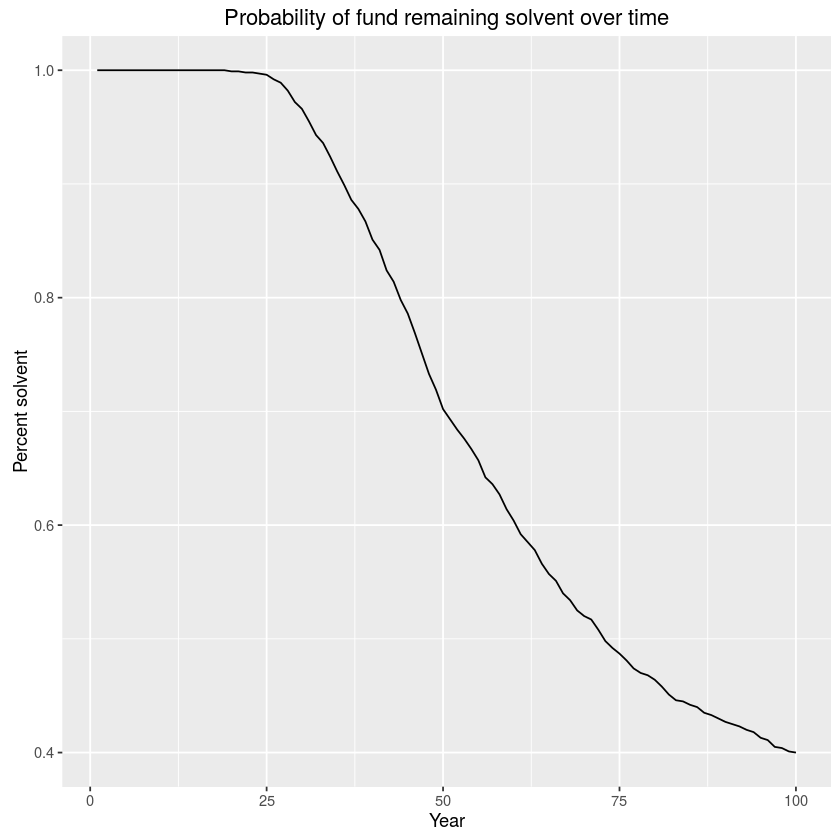

In [273]:
# A function to count the number of entiries in a row that are >0.  
percent_solvent <- function(row) {
    return(sum(row > 0)/length(row))
}

solvent <- apply(df[,-1], 1, percent_solvent)

qplot(x=1:years, y=solvent, geom=c('line')) + xlab("Year") + 
    ylab("Percent solvent") + ggtitle("Probability of fund remaining solvent over time")

### Observation

At the 25 year mark, it's likely to remain solvent 98% of the time.  But it is at that time that the probability takes a sharp turn downward.  After 50 years, there's only a 65% chance of a non-zero principle.  Becoming insolvent after 100 years is more likely than not.

### Objective

There are a number of adjustments that can be made to effect the probability of remaining solvent.  
- Increase the initial principle.
- Iinvest principle with higher or lower risk/return profile.  
- Commit to keeping the fund 'whole', that is, don't extract a payment when the principle is inadequate, and instead make a payment into the principle to help it recover.  

First, consider a higher initial principle.  The values of 20%, 50% and 100% excess principle are considered.

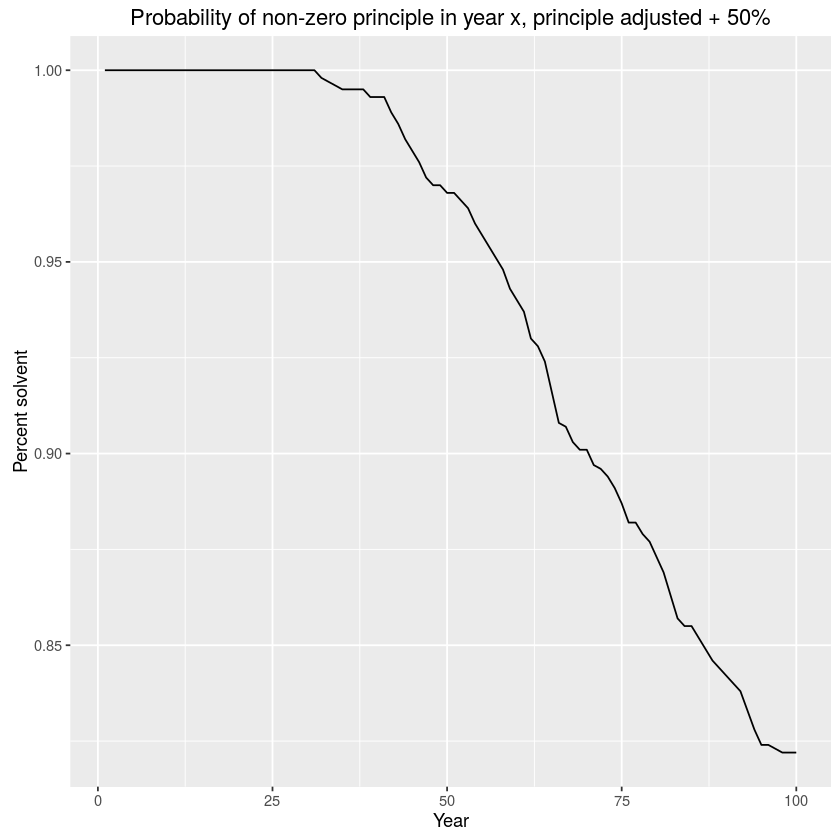

In [281]:
# Calculate another batch of trials. 
N <- test_runs
#set.seed(100+N)
df_ppr <- data.frame( year=1:years)

for (n in 1:N ) {
    principle.growth <- 
        rnorm(years,principle.growth_rate,principle.growth_std)
    payment.growth <- 
        rnorm(years, payment.growth_rate, payment.growth_std)
    col <- calc_principles_series(principle.initial*1.5,         ## extra %
                                  payment.initial, 
                                  principle.growth, 
                                  payment.growth, 
                                  c())
    df_ppr <- cbind(df_ppr, col)
}
#df <- df[,-1]  ## Drop the year column?
names(df_ppr) <- c('year', 1:N)
#dim(df_ppr)

solvent_ppr <- apply(df_ppr[,-1], 1, percent_solvent)

qplot(x=1:years, y=solvent_ppr, geom="line") + xlab("Year") + 
    ylab("Percent solvent") + 
    ggtitle("Probability of non-zero principle in year x, principle adjusted + 50%")


### Observation

With a principle twice the size of the ideal, there greater than 96% chance that the fund will remain solvent after 100 years (not plotted).  With an extra 50% principle, the chances the principle survives 100 years is better than 80%.  And with an extra 20% principle, the odds are beter than 60% (not plotted).  

#### Future work
Plot a family of %extra curves on the same graph for visual comparison. 


### Objective
Vary the risk and return profile, while holding to the efficient frontier.  Data is again gatherd from ifa.com.  This time for portfolios 20 and 80.  Additionally, data for portfolio 50 was taken for a 25 year and 35 year time horizon, each of which happen to have higher return and lower volatility.  

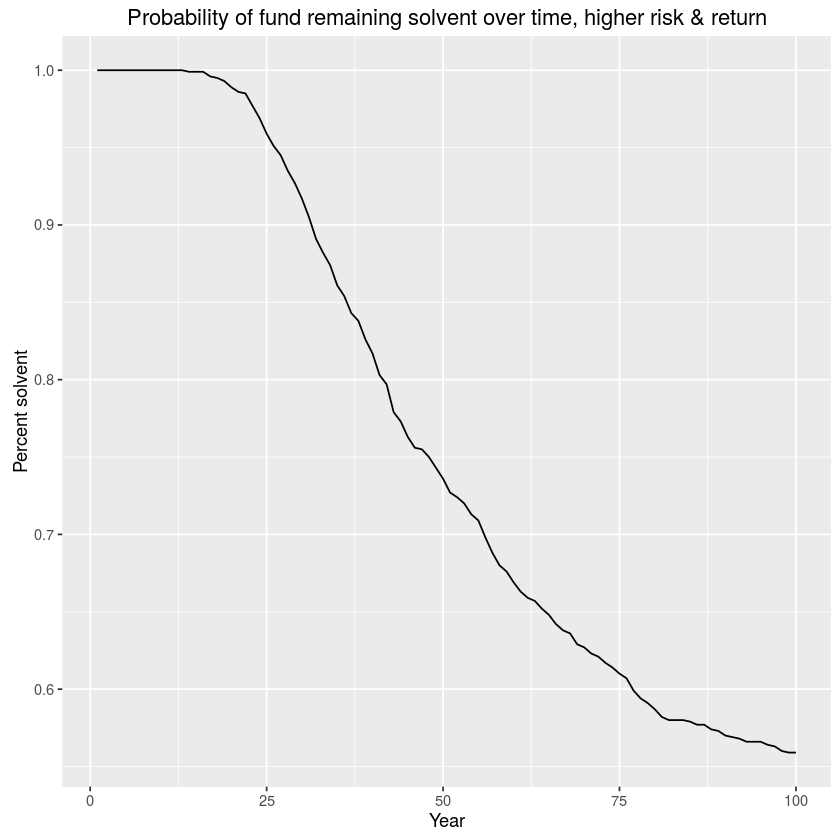

In [282]:
#set.seed(100+N)
N <- test_runs

df_rr <- data.frame( year=1:years)

## Values taken from IFA.com, Portfolio 80, Jan 2000 to Jan 2016. 
principle.growth_rate_adjusted <- 6.66
principle.growth_std_adjusted <-  13.86
## Values taken from IFA.com, Portfolio 20, Jan 2000 to Jan 2016. 
#principle.growth_rate_adjusted <- 3.75
#principle.growth_std_adjusted <-  3.43

## Values taken from IFA.com, Portfolio 50, Jan 1980 to Jan 2016. 
#principle.growth_rate_adjusted <- 9.28
#principle.growth_std_adjusted <-  8.14

## Values taken from IFA.com, Portfolio 50, Jan 1990 to Jan 2016. 
#principle.growth_rate_adjusted <- 6.86
#principle.growth_std_adjusted <-  7.99


for (n in 1:N ) {
    principle.growth <- 
        rnorm(years,principle.growth_rate_adjusted,principle.growth_std_adjusted)
    payment.growth <- 
        rnorm(years, payment.growth_rate, payment.growth_std)
    col <- calc_principles_series(principle.initial,
                                  payment.initial, 
                                  principle.growth, 
                                  payment.growth, 
                                  c())
    df_rr <- cbind(df_rr, col)
}
#df <- df[,-1]  ## Drop the year column?
names(df_rr) <- c('year', 1:N)
#dim(df_rr)

solvent_rr <- apply(df_rr[,-1], 1, percent_solvent)

qplot(x=1:years, y=solvent_rr, geom="line") + xlab("Year") + 
    ylab("Percent solvent") + 
    ggtitle("Probability of fund remaining solvent over time, higher risk & return")



### Observation

With a risk/return of 6.66%/13.86%, the likelihood of solvency is improved slightly relative to the initial test case of 5.43/8.47; after 100 years, the survival is at 62% probability.  

With a risk/return of 3.75/3.43, the likelihood of solvency is drastically reduced.  I attribute this to the smaller difference between the growth rate and inflation rate: a few bad years in a row can become unrecoverable.

Most interestingly, using the 25-year risk/return of portfolio 50 of 6.86%/7.99%, better than 85% of the test runs result in a positive outcome.  With the 35-year risk/return for portfolio 50 of 9.28%/8.14%, all but 3/1000 test runs remained solvent.  

Perhaps the 15 year period from 2000-2015 is not representative?

### Future work

A more extensive analysis of risk/return over various durations identifying best and worst case real-world outcomes.  This may show that the last 15 years was notably volatile.  

Investigate the practicality of achieving efficient-frontier performance, and model the effects of falling short of the target, either with higher-than-expected volatility, or lower-than-expected returns. 

Model the risk and expense of 'making whole' a perpetuity whose principle falls below a safe threshold.  


### Conclusions

A simple fixed-growth-rate perpetuity seemed like a promising approach for modeling a real-world need for a series growing payments over an indefinite (or infinite) period into the future.  

However, when adding volatility into the model, survival rates plummeted and the ideal case was shown to be unrealistic.  

Several appoaches were taken to lessen the possiblity of exhausting the funds of a perpetuity.  The most promising of these was to over-fund the initial principle, say by 20-50%.  Secondly, it may be the case that the recent (15 years) of market volatility and returns are unusually poor, and have adversely affected survival rate.  

----
## Incomplete experiments below this line
----

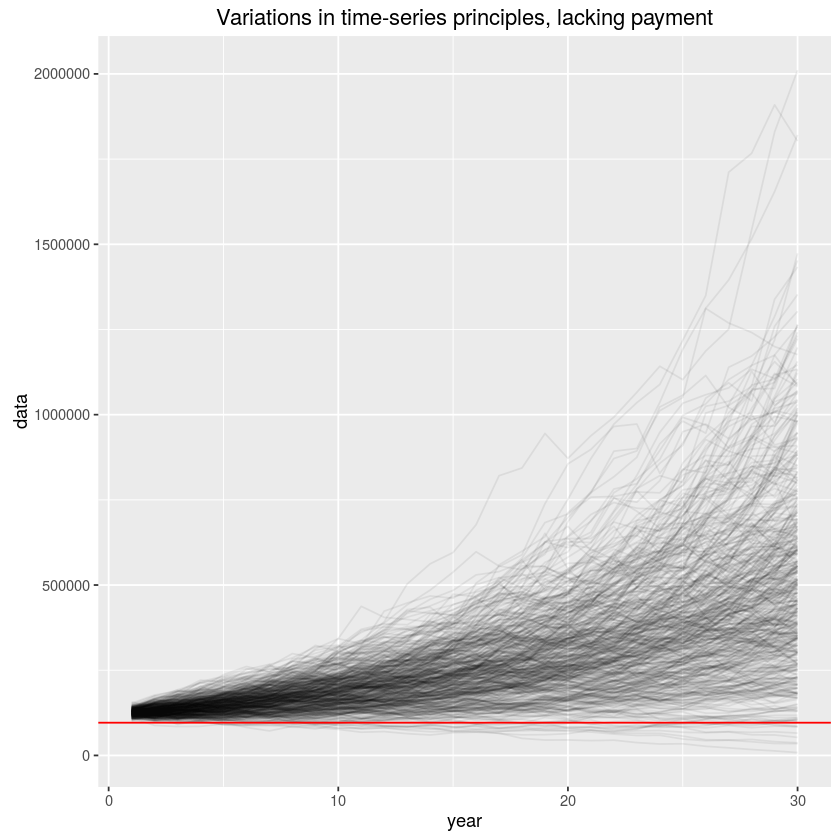

In [301]:
## what if there was no expense?  The survival of the principle should be far more robust.
N <- 500
#set.seed(100+N)
df_zr <- data.frame( year=1:years)


## Observation: reducing stddev produces the expected effect: tighter 
## clustering of the outcomes, and fewer failures.  But, it takes 
## a very small stddev to achieve that.... like 1/5

## increasing growth and reducing stddev
principle.growth_rate_adjusted <- 6.86
principle.growth_std_adjusted <-  7.99


for (n in 1:N ) {
    principle.growth <- 
        rnorm(years,principle.growth_rate_adjusted,(principle.growth_std_adjusted)) 
    payment.growth <- 
        rnorm(years, payment.growth_rate, payment.growth_std)
    col <- calc_principles_series(principle.initial*1.25,           ## Extra principle
                                  payment.initial,                  ## payment is 0
                                  principle.growth, 
                                  payment.growth, ##rep(0, each=years), ## growth of payment is 0
                                  c())
    df_zr <- cbind(df_zr, col)
}
#df <- df[,-1]  ## Drop the year column?
names(df_zr) <- c('year', 1:N)
#dim(df_rr)

plot = ggplot()
for (t in test_runs_to_plot) {
    pf <- df_zr[years_to_plot, c(1,t+1)]
    names(pf) <- c('year', 'data')
    head(pf)
    plot = plot + geom_line(data=pf, aes(x=year, y=data), alpha=0.066)
}

## Show the plot
plot + theme(legend.position="None") + geom_hline(yintercept=principle.initial, color='red') + 
    ggtitle("Variations in time-series principles, lacking payment")

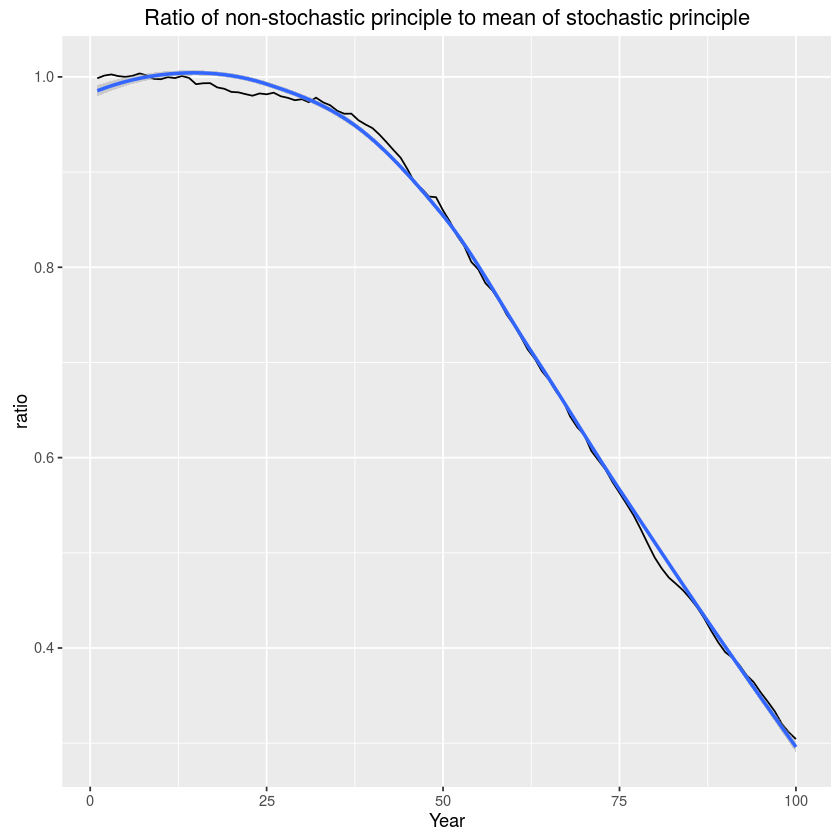

In [258]:
## Find the mean of the 1000 samples for each year... what should be expected?
## Compare the means to the ideal non-stochastic series. 
means <- apply(df[,-1], 1, mean)

qplot(x=1:years, y=principle.non_stochastic_series/means, geom=c('line','smooth')) +
    ggtitle("Ratio of non-stochastic principle to mean of stochastic principle") +
    xlab("Year") + ylab("ratio")

### Observation

The ratio of expected to actual follows a similar path as the probability of remaining solvent. 